In [ ]:
import pandas as pd
import numpy as np  
import re 
from pprint import pprint

# Gensim for topic modeling
import gensim
from gensim.utils import simple_preprocess
from gensim import matutils, models
import gensim.corpora as corpora
from gensim.models import CoherenceModel

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.util import ngrams

# spacy for lemmatization
import spacy
import scipy.sparse
from spacy.lang.en import English
nlp = spacy.load("en_core_web_sm" , disable=['parser', 'ner'])

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import seaborn as sns
 


import warnings
warnings.filterwarnings('ignore')


In [3]:
tweets = pd.read_excel('1May_to_1Jun_Data.xlsx')
tweets.head()

,Unnamed: 0,created_at,id_str,user_name,user_id,in_reply_to_status_id_str,in_reply_to_username,like_count,full_text
0,0,2022-05-10 23:59:46+00:00,1524177405614693888,JoGray39345857,1469035091842286080,NaN,NaN,0,#AmberTurd part 2 from stripper to Shitter! Lo...
1,1,2022-05-10 23:59:36+00:00,1524177364803997952,LynnSinclair15,1116186634133750016,NaN,NaN,2,Sitting here with my nieces and ulla \nthe con...
2,2,2022-05-10 23:59:08+00:00,1524177246591885056,FilmSchoolRooki,1093609176482365056,NaN,NaN,1,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...
3,3,2022-05-10 23:58:55+00:00,1524177193714213120,TiffMCarter,201838819,NaN,NaN,0,At this point it doesn't matter if #Amberheard...
4,4,2022-05-10 23:58:54+00:00,1524177187829686016,DesperateGossip,25446454,NaN,NaN,0,"Johnny Depp and Amber Heard Trial: No Winners,..."


In [41]:
df = tweets.filter(['full_text', "created_at"], axis=1)
df_jan = df[(df['created_at'] > '2022-05-01') & (df['created_at'] < '2022-05-15')]
df2 = df_jan.dropna()
df2.head()

,full_text,created_at
0,#AmberTurd part 2 from stripper to Shitter! Lo...,2022-05-10 23:59:46+00:00
1,Sitting here with my nieces and ulla \nthe con...,2022-05-10 23:59:36+00:00
2,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...,2022-05-10 23:59:08+00:00
3,At this point it doesn't matter if #Amberheard...,2022-05-10 23:58:55+00:00
4,"Johnny Depp and Amber Heard Trial: No Winners,...",2022-05-10 23:58:54+00:00


# Data cleaning

In [9]:
# Remove non-English words

# remove hashtags 
df2['clean_text']  = df2['full_text'].map(lambda x: re.sub("#[A-Za-z0-9_]+", " ", str(x)))

# remove mentions
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("@[A-Za-z0-9_]+"," ", str(x)))

# remove links
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub(r"http\S+"," ", str(x)))

# remove "&amp"
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("&amp"," ", str(x)))

# remove punc 
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("[^A-Za-z0-9]+"," ", str(x)))

# lower case
df2['clean_text']  = df2['clean_text'].apply(lambda x: x.lower())

# remove amber heard and johnny depp
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("amber","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("heard","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("johnny","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("depp","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("ah","", str(x)))
df2['clean_text']  = df2['clean_text'].map(lambda x: re.sub("jd","", str(x)))

# tokenize
df2['clean_text']  = [word_tokenize(row) for row in df2['clean_text']]
# remove stopwords
stop_words = stopwords.words('english')
new_stop_words = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]
stop_words.extend(new_stop_words)
def remove_stopwords(text):
    return [w for w in text if w not in stop_words]
df2['clean_text']  = df2['clean_text'].apply(lambda x: remove_stopwords(x))

In [10]:
df2.head()

,full_text,created_at,clean_text
0,#AmberTurd part 2 from stripper to Shitter! Lo...,2022-05-10 23:59:46+00:00,"[part, 2, stripper, shitter, lol]"
1,Sitting here with my nieces and ulla \nthe con...,2022-05-10 23:59:36+00:00,"[sitting, nieces, ulla, conversation, turd, tr..."
2,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...,2022-05-10 23:59:08+00:00,"[look, simp, mr, road, kill, dude, probably, t..."
3,At this point it doesn't matter if #Amberheard...,2022-05-10 23:58:55+00:00,"[point, matter, telling, truth, exaggerated, w..."
4,"Johnny Depp and Amber Heard Trial: No Winners,...",2022-05-10 23:58:54+00:00,"[trial, winners, experts, say, variety]"


In [11]:
# lemmatization & noun extraction 

def lemmatization(text, allowed_postags=['NOUN']): 
    doc = nlp(' '.join(text)) 
    text_out = [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    return text_out

df2['clean_text'] = df2['clean_text'].apply(lambda x: lemmatization(x))


df2.head()

,full_text,created_at,clean_text
0,#AmberTurd part 2 from stripper to Shitter! Lo...,2022-05-10 23:59:46+00:00,"[part, lol]"
1,Sitting here with my nieces and ulla \nthe con...,2022-05-10 23:59:36+00:00,"[niece, ulla, conversation, trial, ulla, name,..."
2,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...,2022-05-10 23:59:08+00:00,"[simp, road, kill, dude, earth]"
3,At this point it doesn't matter if #Amberheard...,2022-05-10 23:58:55+00:00,"[point, matter, truth, way, experience, surviv..."
4,"Johnny Depp and Amber Heard Trial: No Winners,...",2022-05-10 23:58:54+00:00,"[trial, winner, expert, variety]"


In [12]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed texts together
description_str = ''
for word_list in df2['clean_text'].values:
    description_str += ' '.join(row for row in word_list) + ' '


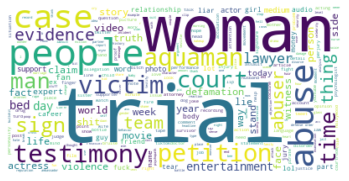

In [13]:
new_stop_words = stopwords.words('english')
# new_stop_words += ['recipe','time', 'dish']

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, stopwords = new_stop_words,
                      contour_color='steelblue', collocations = False,  random_state=1)

# Generate a word cloud
wordcloud.generate(description_str)

# Visualize the word cloud
wordcloud.to_file("unigram_wordcloud_after.png")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

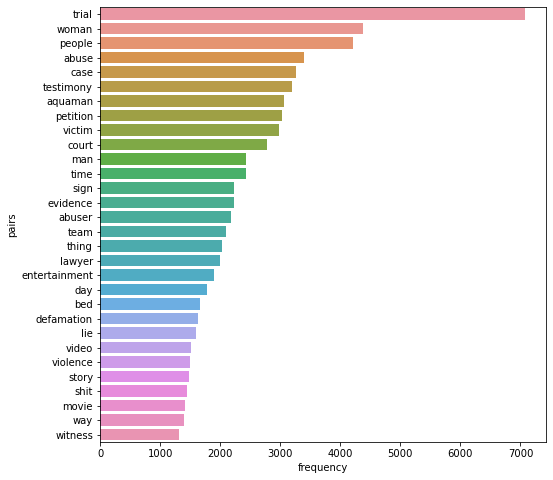

In [14]:
new_tokens = []
for i in df2["clean_text"].tolist():
    new_tokens+= i
counted_2= Counter(new_tokens)
word_pairs =pd.DataFrame(counted_2.items(),columns=["pairs","frequency"]).sort_values(by="frequency",ascending=False)

fig, axes = plt.subplots(1,1,figsize=(8,8))
sns.barplot(x='frequency',y='pairs',data=word_pairs.head(30))

# Topic Modeling for Text


## Create Corpus 

In [15]:
data_lemmatized = df2['clean_text'].tolist()
print(data_lemmatized[:3])

[['part', 'lol'], ['niece', 'ulla', 'conversation', 'trial', 'ulla', 'name', 'native', 'love', 'support'], ['simp', 'road', 'kill', 'dude', 'earth']]


In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [17]:
# Create a dictionary representation of the documents. Each word gets an id
print('Sample word to id mappings:\n', list(id2word.items())[:50])
print()
print('Total Vocabulary Size:', len(id2word))

Sample word to id mappings:
 [(0, 'lol'), (1, 'part'), (2, 'conversation'), (3, 'love'), (4, 'name'), (5, 'niece'), (6, 'support'), (7, 'trial'), (8, 'dude'), (9, 'earth'), (10, 'kill'), (11, 'road'), (12, 'simp'), (13, 'effort'), (14, 'experience'), (15, 'history'), (16, 'matter'), (17, 'point'), (18, 'survivor'), (19, 'truth'), (20, 'way'), (21, 'expert'), (22, 'variety'), (23, 'winner'), (24, 'asshole'), (25, 'word'), (26, 'star'), (27, 'academy'), (28, 'actress'), (29, 'award'), (30, 'performance'), (31, 'talk'), (32, 'time'), (33, 'boy'), (34, 'night'), (35, 'slap'), (36, 'audio'), (37, 'channel'), (38, 'evidence'), (39, 'need'), (40, 'youtube'), (41, 'bully'), (42, 'people'), (43, 'pr'), (44, 'team'), (45, 'week'), (46, 'credit'), (47, 'department'), (48, 'education'), (49, 'movement')]

Total Vocabulary Size: 6504


## Building LDA Model

### Hyperparameter Tuning for LDA Model

In [18]:
# supporting function
def compute_evaluation_values(corpus, dictionary, k):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=20,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    perplexity = lda_model.log_perplexity(corpus)
    
    return [coherence_model_lda.get_coherence(), perplexity]

In [19]:
# Iterate over possible number of topics.
topic_param = []
coherence_score = []
perplexity_score = []

for k in range(2, 20):
    print('topic number: ', k)
    ev = compute_evaluation_values(corpus=corpus, dictionary=id2word, k=k)
    coherence_score.append(ev[0])
    perplexity_score.append(ev[1])
    print('Coherence Score: ', ev[0])
    print('Perplexity Score: ', ev[1])
    print()
    
    topic_param.append(k)

topic number:  2
Coherence Score:  0.3414366159895579
Perplexity Score:  -6.86489669551467

topic number:  3
Coherence Score:  0.28682325377148676
Perplexity Score:  -6.948443603734385

topic number:  4
Coherence Score:  0.3096737209528824
Perplexity Score:  -6.984353392631472

topic number:  5
Coherence Score:  0.31491075868830565
Perplexity Score:  -7.014969088953703

topic number:  6
Coherence Score:  0.35035883483386393
Perplexity Score:  -7.032721624286224

topic number:  7
Coherence Score:  0.3259892342768961
Perplexity Score:  -7.060574148219358

topic number:  8
Coherence Score:  0.2896256946934318
Perplexity Score:  -7.110067048497888

topic number:  9
Coherence Score:  0.30803368358527927
Perplexity Score:  -7.151125075805474

topic number:  10
Coherence Score:  0.31649114597995986
Perplexity Score:  -7.226785784319246

topic number:  11
Coherence Score:  0.31074417662172543
Perplexity Score:  -7.4478875386592645

topic number:  12
Coherence Score:  0.3209692339060946
Perplex

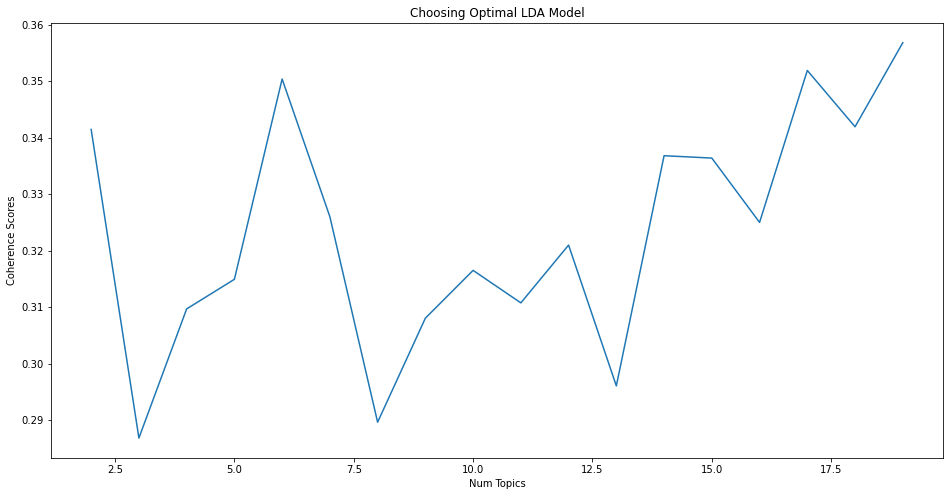

In [21]:
# Show graph
plt.figure(figsize=(16, 8))
plt.plot(topic_param, coherence_score)

plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Coherence Scores")
plt.show()

### Final LDA Model

In [22]:
ntopics_des_name = 6

# We choose 6 because it has the highest coherence score reached before a major drop.

lda_model_des_name = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=ntopics_des_name, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=20,
                                       per_word_topics=True)

In [23]:
# Print the Keyword in the topics
pprint(lda_model_des_name.print_topics())
doc_lda = lda_model_des_name[corpus]

[(0,
  '0.044*"lawyer" + 0.031*"lie" + 0.029*"face" + 0.028*"fan" + '
  '0.020*"relationship" + 0.016*"year" + 0.015*"guy" + 0.014*"bitch" + '
  '0.013*"wife" + 0.012*"ex"'),
 (1,
  '0.097*"petition" + 0.088*"aquaman" + 0.066*"sign" + 0.050*"entertainment" + '
  '0.043*"movie" + 0.021*"dog" + 0.017*"perjury" + 0.015*"actor" + 0.014*"lip" '
  '+ 0.013*"signature"'),
 (2,
  '0.023*"photo" + 0.019*"audio" + 0.019*"testimony" + 0.017*"lol" + '
  '0.017*"friend" + 0.014*"eye" + 0.014*"attorney" + 0.014*"show" + '
  '0.013*"sister" + 0.013*"picture"'),
 (3,
  '0.041*"time" + 0.032*"court" + 0.028*"case" + 0.028*"shit" + 0.025*"bed" + '
  '0.024*"evidence" + 0.023*"team" + 0.021*"story" + 0.020*"people" + '
  '0.019*"side"'),
 (4,
  '0.166*"trial" + 0.045*"testimony" + 0.035*"defamation" + 0.021*"expert" + '
  '0.019*"case" + 0.019*"body" + 0.019*"tiktok" + 0.019*"video" + '
  '0.017*"language" + 0.016*"court"'),
 (5,
  '0.074*"woman" + 0.054*"people" + 0.051*"abuse" + 0.049*"victim" + '
  '0

In [24]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))

In [25]:
topic_num = []
print(lda_model_des_name.get_document_topics(corpus))
for n in range(len(df2)):
    get_document_topics = lda_model_des_name.get_document_topics(corpus[n])
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    all_topic = []
    for i in sorted_doc_topics:
        all_topic.append(i[0])
    topic_num.append(all_topic)

In [26]:
df2['Topic'] = topic_num

In [27]:
des_name_final = df2[['full_text', 'clean_text', 'Topic']]
des_name_final.head()

,full_text,clean_text,Topic
0,#AmberTurd part 2 from stripper to Shitter! Lo...,"[part, lol]","[2, 4, 5, 3, 0, 1]"
1,Sitting here with my nieces and ulla \nthe con...,"[niece, ulla, conversation, trial, ulla, name,...","[3, 4, 5, 1, 2, 0]"
2,Look at #AmberHeard simp Mr Road Kill 🙄 dude p...,"[simp, road, kill, dude, earth]","[4, 3, 0, 1, 2, 5]"
3,At this point it doesn't matter if #Amberheard...,"[point, matter, truth, way, experience, surviv...","[5, 0, 3, 2, 1, 4]"
4,"Johnny Depp and Amber Heard Trial: No Winners,...","[trial, winner, expert, variety]","[4, 2, 0, 1, 3, 5]"


### Model Evaluation

In [28]:
# Compute Perplexity
perplexity = lda_model_des_name.log_perplexity(corpus)
print('Perplexity: ', perplexity)  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model_des_name, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.059518258992161
Coherence Score:  0.3398998919078304


## Visualisation

In [29]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

# # feed the LDA model into the pyLDAvis instance
# lda_viz = gensimvis.prepare(ldamodel, corpus, dictionary)

In [30]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model_des_name, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.212532  0.212823       1        1  22.551669
3      0.158054  0.080100       2        1  18.272646
4     -0.048120 -0.329452       3        1  16.598464
0      0.058029 -0.101104       4        1  14.901043
2      0.013683 -0.033408       5        1  14.862474
1     -0.394178  0.171042       6        1  12.813704, topic_info=         Term         Freq        Total Category  logprob  loglift
7       trial  7316.000000  7316.000000  Default  30.0000  30.0000
64   petition  3293.000000  3293.000000  Default  29.0000  29.0000
79      woman  4459.000000  4459.000000  Default  28.0000  28.0000
230   aquaman  3002.000000  3002.000000  Default  27.0000  27.0000
65       sign  2263.000000  2263.000000  Default  26.0000  26.0000
..        ...          ...          ...      ...      ...      ...
28    actress   397.202687   821.168691   Topic6  -4.4530   1.3284
416     tweet   248.190643   393.466205   Topic6  -4.9233   1.5939
475      work   244.103756   394.564800   Topic6  -4.9399   1.5745
73      video   284.167804  1743.202042   Topic6  -4.7879   0.2407
44       team   224.916366  1709.768881   Topic6  -5.0217   0.0263

[304 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
285       1  0.998684       abuse
285       5  0.000977       abuse
80        1  0.999806      abuser
237       4  0.997341  accusation
376       3  0.998180      acting
...     ...       ...         ...
732       5  0.997651          ye
164       1  0.405653        year
164       2  0.006077        year
164       4  0.470983        year
164       5  0.116986        year

[357 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 5, 1, 3, 2])

## Word Count of Topic Keywords

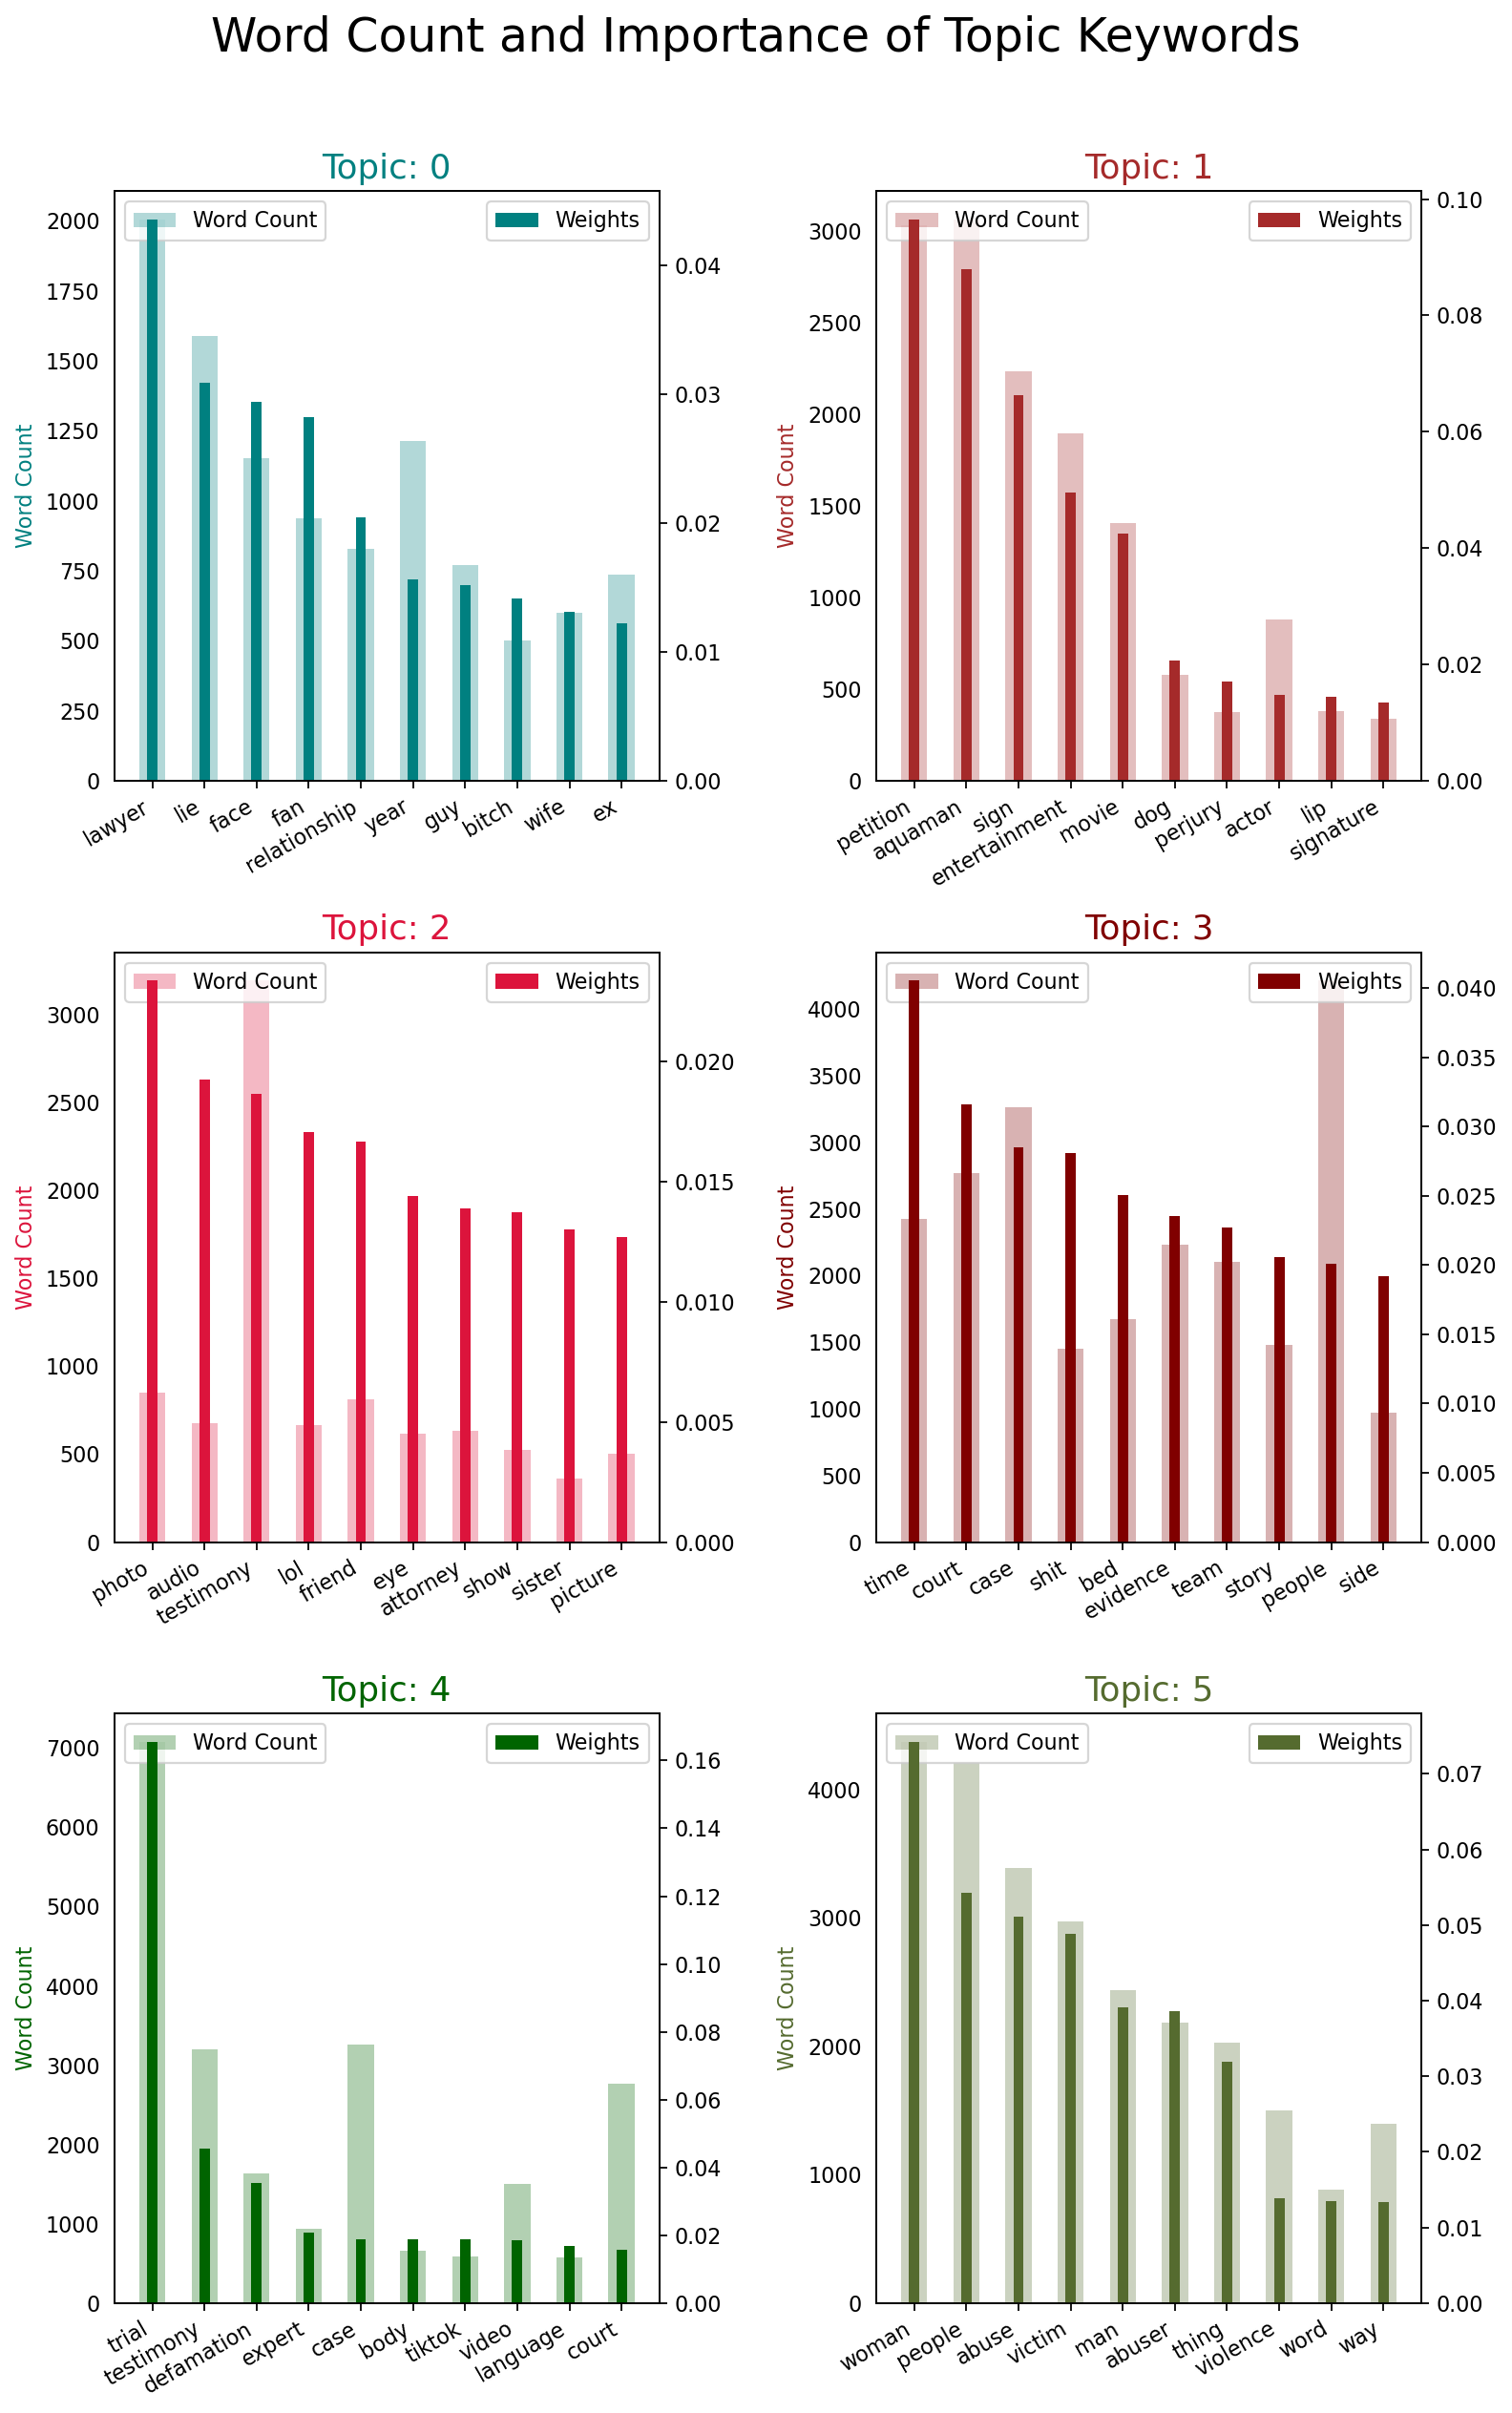

In [31]:
from collections import Counter

topics = lda_model_des_name.show_topics(num_topics=ntopics_des_name, formatted=False)
data_flat = [w for w_list in data_lemmatized for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 2, figsize=(10,15), dpi=160,facecolor='white')
cols = ['#008080', '#A52A2A', '#DC143C', '#800000', '#006400', '#556b2f', '#002366', '#ff8c00', '#FF1493', '#9400D3',
        '#ba55d3', '#b8860b', '#C71585', '#00ff7f', '#00004C', '#00008B', '#B8860B', '#DEB887', '#8A2BE2', '#1b364a']

for i, ax in enumerate(axes.flatten()):
    if i > ntopics_des_name - 1: # break when all topics are shown
        break
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')


fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)   
plt.savefig('unigram_lda_topics_after.png',facecolor=fig.get_facecolor(), transparent=True)
plt.show()
